# **EXERCÍCIO PROGRAMA 3**

## **Alunos:**  

*   Amanda Cristina Mazer - NUSP: 10200951
*   Carlos Alberto Silva de Souza - NUSP: 8539408
*   Leonardo Miranda de Brito - NUSP: 12630364


## **GitHub do projeto + dados:**

*   Link para o GitHub: https://github.com/Giganoide01/MAC5768_EPs
*   Link para a pasta do Google Drive: https://drive.google.com/drive/u/0/folders/1WEzT7nZTrtw9EBntSM8hCzoGQyDAQUIw


## **EP 3.1 - Descrição:**

O EP 3.1 consiste em selecionar 15% do dataset original de imagens em níveis de cinza, realizar tanto segmentação manual (chamada de "Ground truth") quanto segmentação automática nessa seleção do dataset e encontrar as coordenadas da Feret box para ambos os casos. Por fim, as segmentações manual e automática devem ser comparadas de acordo com alguma métrica.


Todo o processo é ilustrado através da imagem a seguir.

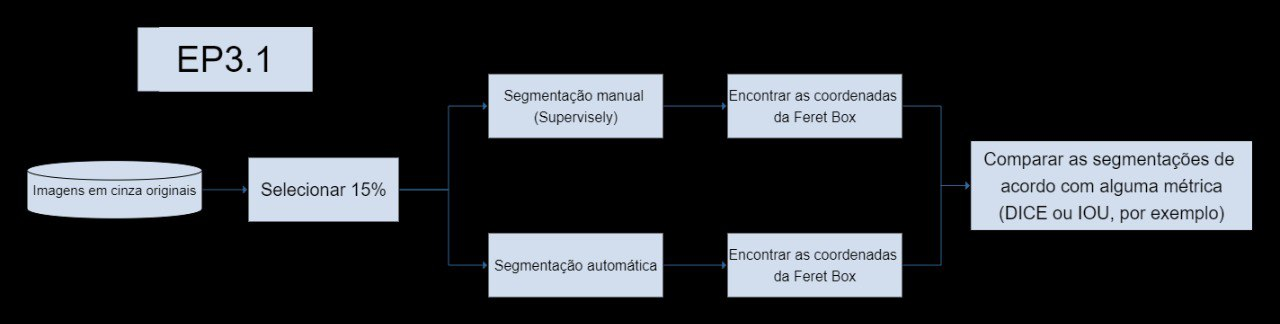

## Carregamento das bibliotecas ##

In [ ]:
from google.colab import drive
import os
import json
import zlib
import numpy as np
import base64
import cv2
from skimage import io, segmentation, filters, feature, morphology, measure, transform
from sklearn import model_selection, decomposition, svm, metrics
import matplotlib.pyplot as plt
import pandas as pd
import random
from joblib import Parallel, delayed


## Pasta do Drive ##

In [ ]:
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/MAC5768 - EPs/')


Mounted at /content/gdrive


## Diretório ##

In [ ]:
diretorio = '/content/gdrive/My Drive/MAC5768 - EPs/'


## Ground truth

Neste trabalho, a segmentação manual, chamada de "Ground truth", foi realizada através do Supervisely em 15% das imagens de cada classe de objetos. Em seguida, os arquivos resultantes contendo as máscaras das segmentações foram exportados em formato .json e constam em uma pasta do Drive, de nome "groundTruth".

Inicialmente, foi criada uma função que lê tais máscaras no formato .json e retorna uma matriz binária e uma função que encontra as coordenadas da Feret box a partir de uma máscara. Algumas das imagens e suas respectivas segmentações manuais podem ser visualizadas na sequência.

In [ ]:
def le_mascara(diretorio):
  '''Lê o arquivo de texto .json do ground truth gerado através do Supervisely
  e retorna uma máscara no formato de matriz binária, em que 0 corresponde ao
  fundo e 1 corresponde ao objeto segmentado.'''

  # Lendo o arquivo de texto .json:
  with open(diretorio,'r') as arq:
    arquivo_texto = json.load(arq)

  # Caso a segmentação tenha sido feita por bitmap:
  if arquivo_texto['objects'][0]['geometryType'] == 'bitmap':
    codigo_imagem = arquivo_texto['objects'][0]['bitmap']['data']
    z = zlib.decompress(base64.b64decode(codigo_imagem))  # decodifica as informações
    n = np.fromstring(z, np.uint8)
    mascara = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool).astype(np.uint8)  # ground truth com janela reduzida

    mascara2 = np.zeros(shape=(arquivo_texto['size']['height'], arquivo_texto['size']['width']))  # ground truth do tamanho da imagem original
    origem = arquivo_texto['objects'][0]['bitmap']['origin']
    for i in range(mascara.shape[0]):
      for j in range(mascara.shape[1]):
        mascara2[i+origem[1], j+origem[0]] += mascara[i,j]
    mascara = mascara2

  # Caso a segmentação tenha sido feita por polígono:
  elif arquivo_texto['objects'][0]['geometryType'] == 'polygon':
    mascara = np.zeros(shape=(arquivo_texto['size']['height'], arquivo_texto['size']['width']))
    pontos_poligono = np.array(arquivo_texto['objects'][0]['points']['exterior'])
    cv2.fillConvexPoly(mascara, pontos_poligono, 1)    

  return mascara.astype(np.uint8)


In [ ]:
def encontra_feret_box(mascara):
  '''Encontra as coordenadas da Feret box da máscara fornecida em formato de matriz
  binária e retorna y e x mínimos e y e x máximos.'''

  for regiao in measure.regionprops(mascara):
    y_min, x_min, y_max, x_max = regiao.bbox  # feret box
  
  if 'y_min' in locals():
    return y_min, x_min, y_max, x_max
  else:
    return 0, 0, mascara.shape[0], mascara.shape[1] 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


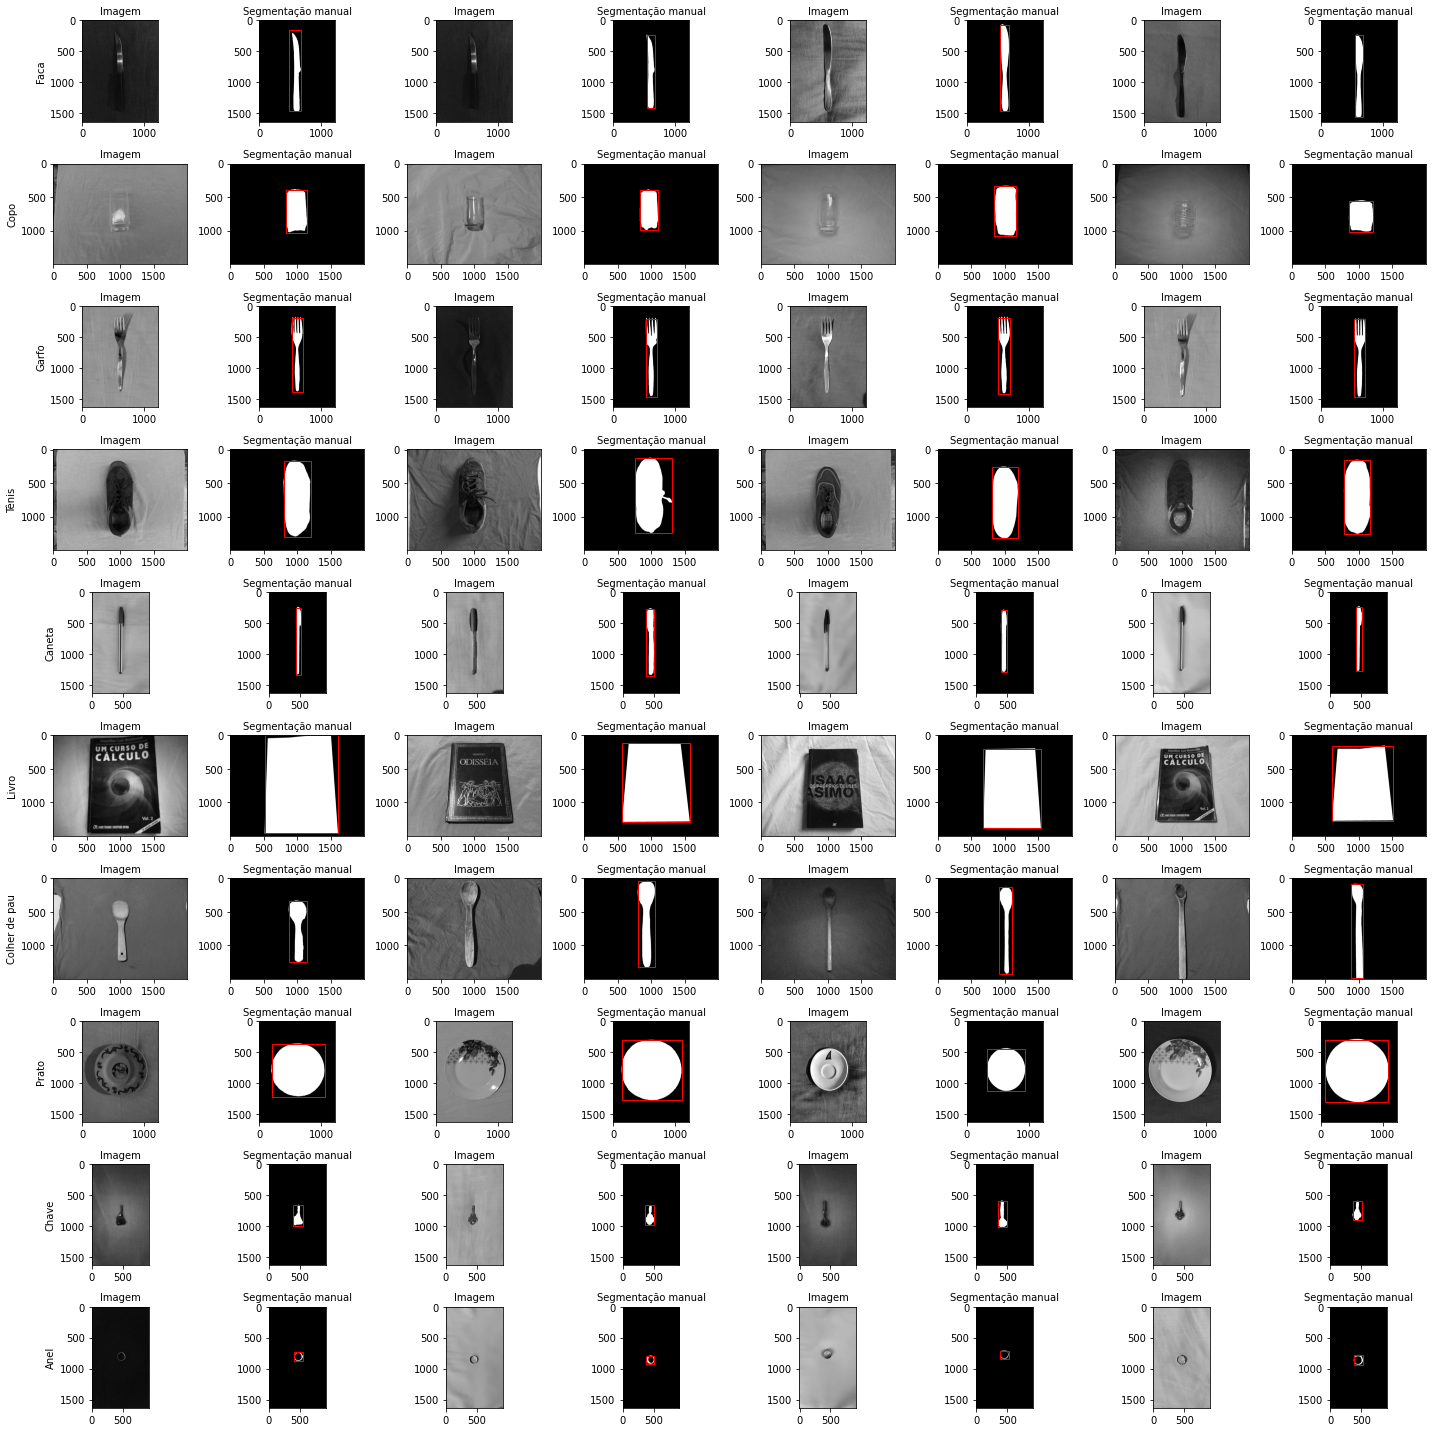

In [ ]:
# Visualização de alguns Ground truth:
classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')

j = 1
plt.figure(figsize=(20, 20))
for i in range(classes.shape[0]):
  classe = classes.iloc[i]['descricao']
  arquivos = os.listdir(diretorio + 'groundTruth/' + classe)
  amostras = random.sample(arquivos, 4)  # sorteando imagens para mostrar

  for a, amostra in enumerate(amostras):

    amostra_im = amostra
    if '-cin' not in amostra_im:
      amostra_im = amostra[:amostra.index('.')] + '-cin.jpg.json'

    # Lendo a imagem amostrada e a respectiva máscara:
    im = io.imread(diretorio + 'originalGrayDataset/' + classe + '/' + amostra_im[:amostra_im.index('.json')]) 
    seg = le_mascara(diretorio + 'groundTruth/' + classe + '/' + amostra)

    # Plot da imagem em níveis de cinza:
    plot_imagem = plt.subplot(classes.shape[0], 2*len(amostras), j)
    plt.imshow(im, cmap='gray')
    plt.title('Imagem', fontsize=10)
    if a == 0:
      plt.ylabel(classe, fontsize=10)

    # Plot da máscara binária:
    plot_imagem = plt.subplot(classes.shape[0], 2*len(amostras), j+1)
    plt.imshow(seg, cmap='gray')
    plt.title('Segmentação manual', fontsize=10)

    # Feret box:
    y_min, x_min, y_max, x_max = encontra_feret_box(seg)
    feret_box = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, edgecolor='r', facecolor='none')
    plot_imagem.add_patch(feret_box)
    j += 2

plt.tight_layout()
plt.show()


A função seguinte foi criada com o objetivo de ler todas as máscaras das segmentações manuais realizadas e armazená-las em um dicionário de acordo com a classe dos objetos. Assim como as coordenadas da Feret box de todas as máscaras também são armazenadas em um dicionário. Isso é feito para posteriormente realizar a comparação com as máscaras obtidas em uma segmentação automática.

In [ ]:
def le_ground_truth(diretorio):
  '''Lê todas as segmentações manuais de 15% do dataset de imagens em níveis de
  cinza e retorna um dicionário com as máscaras binárias e um dicionário com as
  respectivas Feret box.'''

  # Criando os dicionários para armazenamento das variáveis:
  ground_truth = {}
  feret_box = {}

  classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')
  for i in range(classes.shape[0]):  # para cada classe de objetos

    classe = classes.iloc[i]['descricao']
    ground_truth[classe] = []
    feret_box[classe] = []
    arquivos = os.listdir(diretorio + classe)

    for arquivo in arquivos:

      # Lendo o arquivo resultante da segmentação manual e armazenando a máscara binária resultante:
      mascara = le_mascara(diretorio + classe + '/' + arquivo)  
      ground_truth[classe].append(mascara)

      # Encontrando as coordenadas da Feret box e armazenando:
      y_min, x_min, y_max, x_max = encontra_feret_box(mascara)  
      feret_box[classe].append([y_min, x_min, y_max, x_max])

  return ground_truth, feret_box


In [ ]:
# Armazenando todos os Ground truth e as respectivas coordenadas das Feret box para posterior comparação:
ground_truth, feret_box_ground_truth = le_ground_truth(diretorio + 'groundTruth/')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


## Segmentação automática

A função a seguir foi criada para realizar segmentação automática de objetos em uma imagem. O método base escolhido foi de segmentação por região combinado com outras técnicas a fim de melhorar a segmentação.

Nela, inicialmente, a imagem fornecida é filtrada com um filtro da mediana; na sequência, a técnica de limiarização de Otsu é utilizada para obter um valor limiar para separar o fundo da imagem do objeto; em seguida, as técnicas de fechamento e também de redução de artefatos na segmentação são utilizadas a fim de otimizar a função.

In [ ]:
def segmentacao_regiao(imagem):
  '''Segmenta automaticamente objetos da imagem fornecida através de filtragem com
  filtro da mediana, limiarização de Otsu, fechamento, e redução de artefatos e
  retorna uma matriz binária da segmentação realizada, em que 0 corresponde ao fundo
  e 1 corresponde ao objeto segmentado.
  Adaptado de: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py'''

  imagem_filtrada = filters.rank.median(imagem, morphology.disk(5))  # aplicação do filtro da mediana
  limite = filters.threshold_otsu(imagem_filtrada)  # limiarização por Otsu
  imagem_fechamento = morphology.closing(imagem < limite, morphology.square(3))  # fechamento
  imagem_sem_artefatos = segmentation.clear_border(imagem_fechamento)  # redução de artefatos
  segmentacao = measure.label(imagem_sem_artefatos)

  # Encontrando o valor mais recorrente sem ser zero (fundo):
  contagens = np.bincount(segmentacao.flatten())
  if len(contagens) > 1:
    valor = np.where(contagens == np.max(contagens[1:]))[0][0]

    for i in range(segmentacao.shape[0]):
      for j in range(segmentacao.shape[1]):
        if segmentacao[i,j] != 0 and segmentacao[i,j] != valor:
          segmentacao[i,j] = 0

  return segmentacao


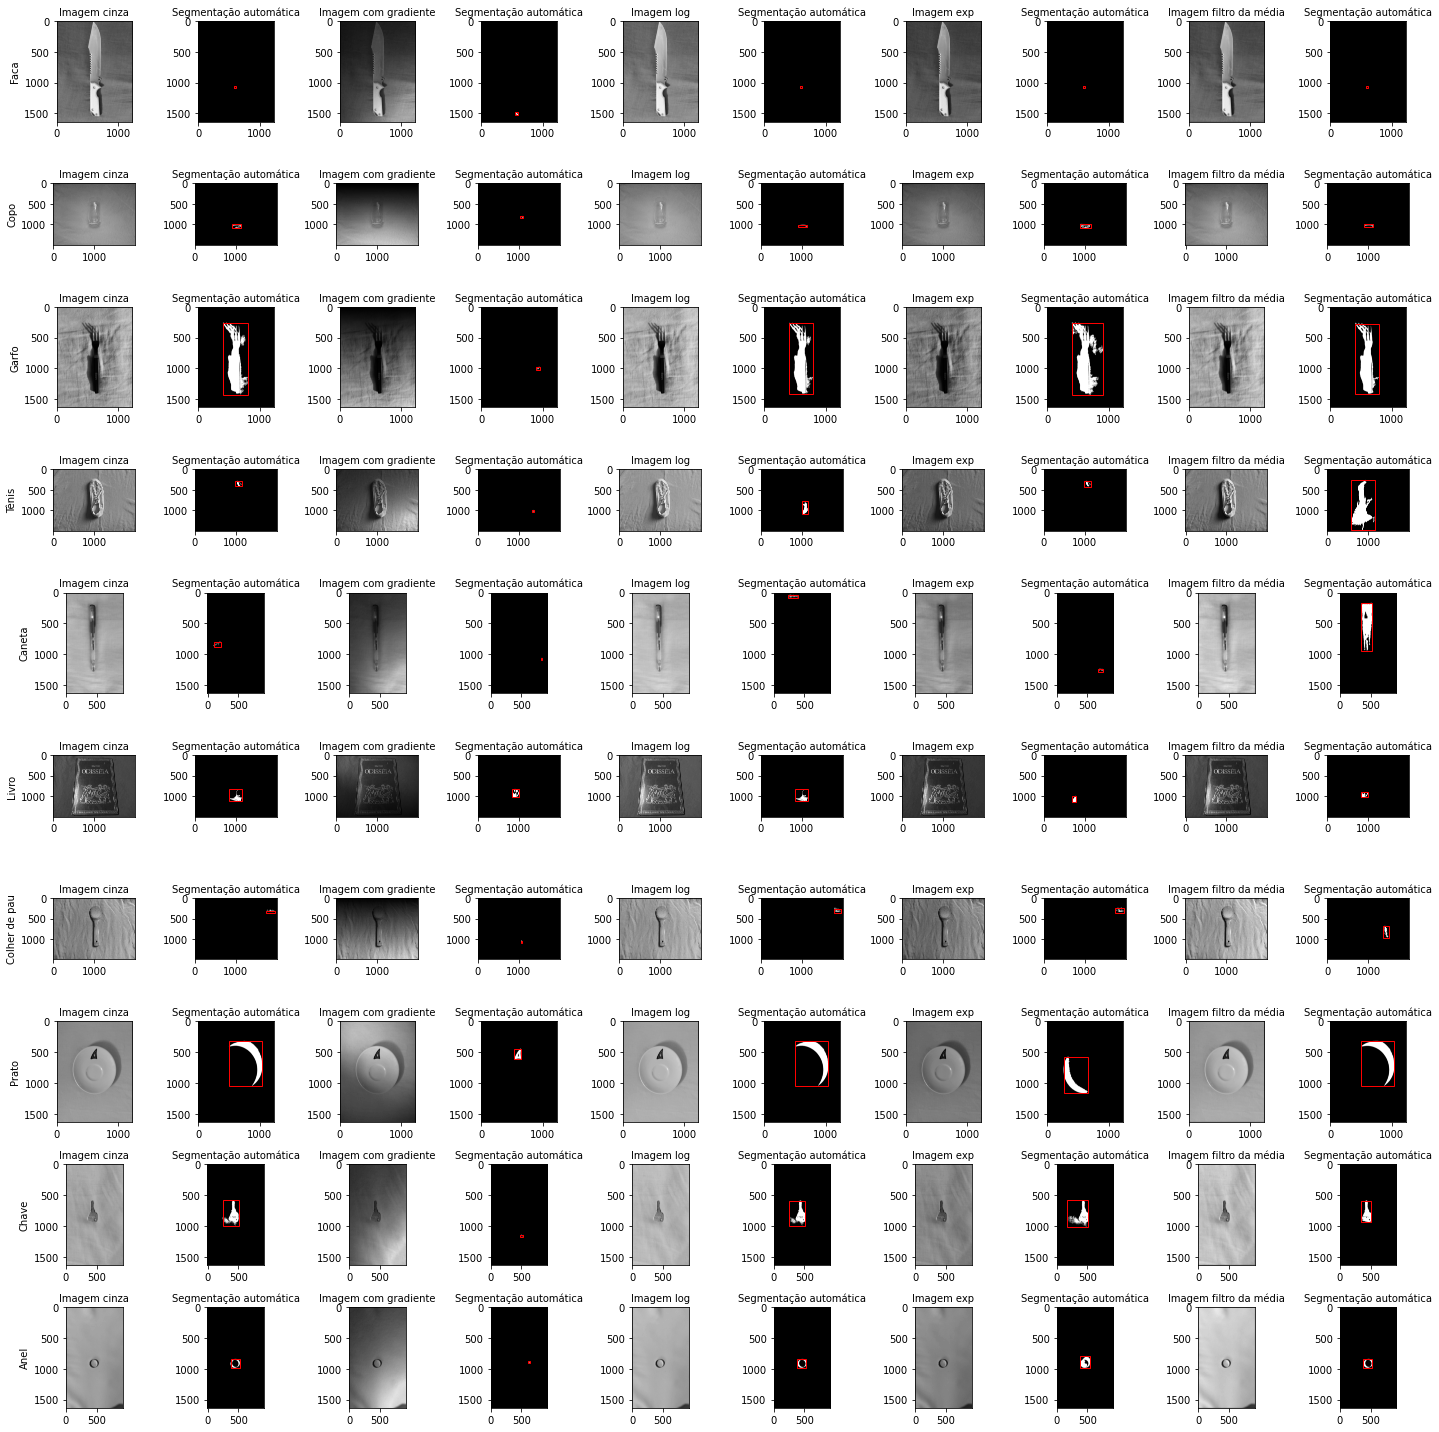

In [ ]:
# Visualização de algumas segmentações automáticas por região:
classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')
extensao = ['cin', 'grad', 'log', 'exp', 'med']
titulos = ['Imagem cinza', 'Imagem com gradiente', 'Imagem log', 'Imagem exp', 'Imagem filtro da média']

j = 1
plt.figure(figsize=(20, 20))
for i in range(classes.shape[0]):
  classe = classes.iloc[i]['descricao']
  nomes_imagens = os.listdir(diretorio + 'originalGrayDataset/' + classe)
  amostra = random.sample(nomes_imagens, 1)[0]  # sorteando uma imagem para mostrar

  for k in range(len(extensao)):  # para mostrar a mesma imagem com diferentes tipos de filtro (EP2.1)

    # Lendo a imagem amostrada:
    if extensao[k] == 'cin':
      im = io.imread(diretorio + 'originalGrayDataset/' + classe + '/' + amostra) 
    else:
      im = io.imread(diretorio + 'augmentedDataset/' + classe + '/' + extensao[k] + '/' + amostra[:amostra.index('.')] + '-' + extensao[k] + '.jpg')

    # Segmentando automaticamente essa imagem:
    seg = segmentacao_regiao(im)

    # Plot da imagem em níveis de cinza:
    plot_imagem = plt.subplot(classes.shape[0], 2*len(extensao), j)
    plt.imshow(im, cmap='gray')
    plt.title(titulos[k], fontsize=10)
    if k == 0:
      plt.ylabel(classe, fontsize=10)

    # Plot da segmentação automática:
    plot_imagem = plt.subplot(classes.shape[0], 2*len(extensao), j+1)
    plt.imshow(seg, cmap='gray')
    plt.title('Segmentação automática', fontsize=10)

    # Feret box:
    y_min, x_min, y_max, x_max = encontra_feret_box(seg)
    feret_box = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, edgecolor='r', facecolor='none')
    plot_imagem.add_patch(feret_box)
    j += 2

plt.tight_layout()
plt.show()


A função a seguir foi criada com o objetivo de segmentar automaticamente todas as imagens dos mesmos 15% do dataset original em níveis de cinza que foram segmentados manualmente. Da mesma forma, as máscaras binárias resultantes e as coordenadas da Feret box foram armazenadas em dicionários para posterior comparação com as máscaras obtidas das segmentações manuais (Ground truth).

In [ ]:
def segmenta_15dataset(diretorio):
  '''Realiza segmentação automática por região dos mesmos 15% do dataset original
  do qual existe o ground truth. Retorna um dicionário com as máscaras binárias e
  um dicionário com as respectivas Feret box.'''

  # Criando os dicionários para armazenamento das variáveis:
  segmentacoes = {}
  feret_box = {}

  classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')
  for i in range(classes.shape[0]):  # para cada classe de objetos

    classe = classes.iloc[i]['descricao']
    segmentacoes[classe] = []
    feret_box[classe] = []
    arquivos = os.listdir(diretorio + 'groundTruth/' + classe)

    for arquivo in arquivos:

      nome_imagem = arquivo[:arquivo.index('.json')]
      if '-cin' not in nome_imagem:
        nome_imagem = arquivo[:arquivo.index('.')] + '-cin.jpg'

      # Lendo a imagem, segmentando e armazenando a máscara binária resultante:
      imagem = io.imread(diretorio + 'originalGrayDataset/' + classe + '/' + nome_imagem)
      segmentacao = segmentacao_regiao(imagem)
      segmentacoes[classe].append(segmentacao)

      # Encontrando as coordenadas da Feret box e armazenando:
      y_min, x_min, y_max, x_max = encontra_feret_box(segmentacao)
      feret_box[classe].append([y_min, x_min, y_max, x_max])

  return segmentacoes, feret_box


In [ ]:
# Armazenando todas as segmentações automáticas e as coordenadas das Feret box para comparação:
segmentacoes_automaticas, feret_box_segmentacoes_automaticas = segmenta_15dataset(diretorio)


## Métrica de segmentação

A métrica escolhida para analisar as segmentações automáticas, tendo como base as segmentações manuais, foi a DICE (F1 Score). Através dela, é possível calcular um coeficiente que indica quanto a segmentação automática se aproxima da segmentação manual (referência), em que 0 indica nenhuma correspondência e 1 indica total correspondência entre as segmentações.

In [ ]:
def calcula_dice(ground_truth, segmentacoes_automaticas):
  '''Calcula o coeficiente DICE (F1 Score) entre todos os ground truth e segmentações
  automáticas correspondentes e imprime a média dos coeficientes para cada classe
  de objeto.'''

  medias_dice = {}
  
  for classe in ground_truth:
    if ground_truth[classe][0].shape == segmentacoes_automaticas[classe][0].shape:
      coeficientes = []
      for i, seg in enumerate(ground_truth[classe]):
        mascara_verdadeira = seg.astype(np.bool)
        mascara_analisada = segmentacoes_automaticas[classe][i].astype(np.bool)

        if mascara_verdadeira.sum() + mascara_analisada.sum() == 0:
          coeficiente_dice = 0
        else:
          intersecao = np.logical_and(mascara_verdadeira, mascara_analisada)
          coeficiente_dice = 2. * intersecao.sum() / (mascara_verdadeira.sum() + mascara_analisada.sum())

        coeficientes.append(coeficiente_dice)
    
      medias_dice[classe] = sum(coeficientes)/len(coeficientes)

  # Impressão dos resultados:
  print('MÉDIAS DO COEFICIENTE DICE:\n')
  print('CLASSE    COEFICIENTE')
  for classe in medias_dice:
    print(classe + '    ' + str(medias_dice[classe]))


In [ ]:
calcula_dice(ground_truth, segmentacoes_automaticas)

MÉDIAS DO COEFICIENTE DICE:

CLASSE    COEFICIENTE
Faca    0.5057814114930073
Copo    0.05356699867381915
Garfo    0.4819535198295693
Tênis    0.38209748943325444
Caneta    0.3460611394080613
Livro    0.2587297236699227
Colher de pau    0.24403970795178748
Prato    0.4314963530694914
Chave    0.570362717489266
Anel    0.24264211999390708


## **EP 3.2 - Descrição:**
O EP 3.2 consiste em segmentar automaticamente o dataset aumentado, encontrando as coordenadas da Feret box para cada caso e recortando a imagem original a partir dessas coordenadas. Em seguida, é feita a extração de características de cada imagem por meio de "Principal Component Analysis" (PCA) para treinar um modelo de aprendizado de máquina ("Support Vector Machine") e classificar objetos com base na região de interesse identificada pela segmentação automática.

Esse processo é ilustrado através da imagem a seguir.

OBS.: o dataset normalizado não foi utilizado neste trabalho pelo fato de que amostras de testes com esse dataset apresentaram performance bastante ruim para as segmentações automáticas. Ademais, apenas o dataset aumentado foi selecionado a fim de reduzir o tempo de execução do EP.

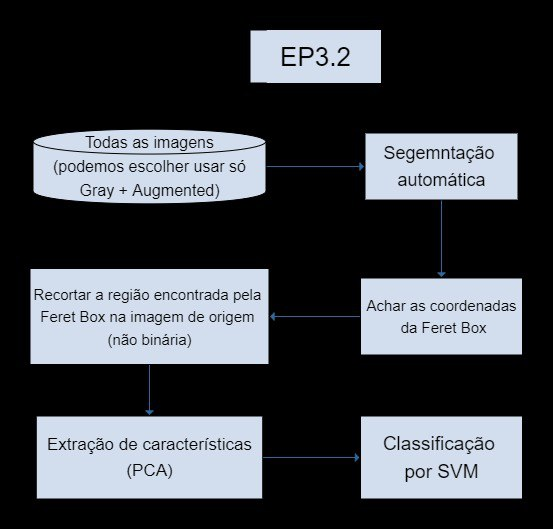

## Extração de características, PCA e classificação

In [ ]:
def segmentacao_imagem(diretorio_completo_imagem):
  '''Lê uma imagem, a segmenta automaticamente, a recorta de acordo com as coordenadas
  das Feret box, redefine seu tamanho para 50x50 e a transforma em um vetor unidimensional.'''
  
  imagem = io.imread(diretorio_completo_imagem)  # lendo a imagem
  segmentacao = segmentacao_regiao(imagem)  # segmentando a imagem
  y_min, x_min, y_max, x_max = encontra_feret_box(segmentacao)  # feret box da segmentação
  imagem = transform.resize(imagem[y_min:y_max, x_min:x_max], (50,50), anti_aliasing=False)  # corte e redefinição do tamanho da imagem
  caracteristicas_imagem = np.reshape(imagem, 50*50)  # vetorização da imagem
  
  return caracteristicas_imagem


def segmentacao_caracteristicas_dataset(diretorio):
  '''Realiza segmentação automática do dataset aumentado, encontra as coordenadas
  das Feret box de cada imagem, recorta a região da imagem através dessas coordenadas,
  redefine o tamanho dessas regiões para 50x50, vetoriza as regiões e devolve a 
  matriz contendo as regiões de interesse de todas as imagens do dataset.'''

  datasets = ['originalGrayDataset', 'augmentedDataset']
  classes = classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')

  # Criando a matriz de características para o treinamento do modelo:
  matriz_caracteristicas = np.empty((0, 50*50))
  codigos_imagens = []

  for dataset in datasets:
    if dataset == 'augmentedDataset':
      extensoes = ['grad', 'log', 'exp', 'med']
    else:
      extensoes = ['']

    for i in range(classes.shape[0]):
      classe = classes.iloc[i]['descricao']  # nomes das classes de objetos
      codigo = classes.iloc[i]['codigo']  # códigos numéricos das classes de objetos

      for extensao in extensoes:
        nomes_imagens = os.listdir(diretorio + dataset + '/' + classe + '/' + extensao)  # listando os nomes das imagens

        for nome in nomes_imagens:
          codigos_imagens.append(codigo)  # armazenando os códigos das imagens da pasta atual
        
        # Paralelizando as segmentações automáticas do grupo de imagens:
        caracteristicas_imagens = Parallel(n_jobs=-1)(delayed(segmentacao_imagem)(diretorio + dataset + '/' + classe + '/' + extensao + '/' + nome) for nome in nomes_imagens)
        
        # Organizando a matriz de características:
        for c in caracteristicas_imagens:
          matriz_caracteristicas = np.vstack((matriz_caracteristicas, c))
                
  codigos_imagens = np.array(codigos_imagens)

  return matriz_caracteristicas, codigos_imagens


In [ ]:
def classificacao_modelo_pca(matriz_caracteristicas, codigos_imagens):
  '''A partir da matriz de características do dataset de imagens, treina um modelo
  para classificação de objetos e imprime o resultado das classificações feitas
  comparadas às verdadeiras.'''

  # Separando o dataset para treino e para teste:
  x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(matriz_caracteristicas, codigos_imagens, test_size=0.25, random_state=42)
  
  # Calculando PCA:
  n_components = 150
  pca = decomposition.PCA(n_components=n_components).fit(x_treino)
  x_treino_pca = pca.transform(x_treino)
  x_teste_pca = pca.transform(x_teste)

  # Treinando um modelo de classificação SVM:
  parametros = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
  clf = model_selection.GridSearchCV(svm.SVC(), parametros)
  clf = clf.fit(x_treino_pca, y_treino)
  y_pred = clf.predict(x_teste_pca)

  # Impressão dos resultados:
  classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')
  lista_classes = []
  for i in range(classes.shape[0]):
    lista_classes.append(classes.iloc[i]['descricao'])
  contagens_reais = np.bincount(y_teste)
  contagens_classificadas = np.bincount(y_pred)
  
  print('RESULTADOS DA CLASSIFICAÇÃO DO DATASET TESTE:\n')
  print('CLASSE    Nº IMAGENS REAIS    Nº IMAGENS CLASSIFICADAS')
  for c, classe in enumerate(lista_classes):
    print(classe + '    ' + str(contagens_reais[c+1]) + '    ' + str(contagens_classificadas[c+1]))

  return y_teste, y_pred


In [ ]:
# Segmentando automaticamente as imagens do dataset e obtendo a matriz de características para treinar um modelo de classificação:
matriz_caracteristicas, codigos_imagens = segmentacao_caracteristicas_dataset(diretorio)

# Classificando objetos do dataset através de PCA:
y_teste, y_pred = classificacao_modelo_pca(matriz_caracteristicas, codigos_imagens)

RESULTADOS DA CLASSIFICAÇÃO DO DATASET TESTE:

CLASSE    Nº IMAGENS REAIS    Nº IMAGENS CLASSIFICADAS
Faca    338    217
Copo    451    1169
Garfo    276    185
Tênis    452    374
Caneta    478    432
Livro    445    411
Colher de pau    351    233
Prato    461    393
Chave    414    295
Anel    429    386


## Métrica de classificação

A partir dos dados de teste e dos resultados obtidos com o modelo, é possível avaliar quantitativamente o modelo de treino através de um relatório de classificação e da matriz de confusão.

In [ ]:
def relatorio_classificacao(y_teste, y_pred):
  '''Avaliação quantitativa do modelo no dataset teste.'''

  classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')
  lista_classes = []
  for i in range(classes.shape[0]):
    lista_classes.append(classes.iloc[i]['descricao'])

  print('RELATÓRIO DE CLASSIFICAÇÃO:\n')
  print(metrics.classification_report(y_teste, y_pred, target_names=lista_classes))

  print('')
  print('MATRIZ DE CONFUSÃO:\n')
  print(metrics.confusion_matrix(y_teste, y_pred, labels=range(classes.shape[0])))


In [ ]:
relatorio_classificacao(y_teste, y_pred)

RELATÓRIO DE CLASSIFICAÇÃO:

               precision    recall  f1-score   support

         Faca       0.86      0.55      0.67       338
         Copo       0.30      0.76      0.43       451
        Garfo       0.86      0.58      0.69       276
        Tênis       0.79      0.65      0.72       452
       Caneta       0.64      0.58      0.61       478
        Livro       0.87      0.80      0.83       445
Colher de pau       0.58      0.39      0.47       351
        Prato       0.88      0.75      0.81       461
        Chave       0.95      0.68      0.79       414
         Anel       0.67      0.60      0.64       429

     accuracy                           0.64      4095
    macro avg       0.74      0.63      0.66      4095
 weighted avg       0.73      0.64      0.67      4095


MATRIZ DE CONFUSÃO:

[[  0   0   0   0   0   0   0   0   0   0]
 [  0 186  99   3   8  12   6   4   4   1]
 [  0   6 345   3  13  20   4  28   9   1]
 [  0   4  69 159   6  12   2   7   5   1]
 [  

## Considerações finais

*   Sobre a segmentação automática: o algoritmo Otsu, que foi um dos blocos construtores da nossa função de segmentação, possui grandes limitações. Por exemplo:
1. No caso de haver ruído no fundo que possui a mesma cor do objeto, o Otsu classifica ruído como objeto;
2. No caso de objeto e fundo terem cores similares, porém haver ruído de uma cor muito discrepante, o algoritmo pode segmentar objeto+fundo ou ruído como objeto (e o resto como fundo);
3. Mesmo sem a presença de ruído, o objeto pode conter diferentes cores em seu interior (caso dos livros ou tênis, por exemplo), o que faz com que o algoritmo Otsu classifique partes do objeto como fundo.

*   Além disso, o parâmetro de janela no filtro da mediana e o parâmetro do algoritmo de fechamento poderiam passar por uma busca em grade para encontrar os valores que maximizassem o coeficiente DICE na segmentação automática para o conjunto de dados segmentados manualmente. Usamos valores padrão nesse caso.

*   Analisando as médias dos coeficientes DICE da métrica de segmentação, foi possível observar que a função de segmentação automática criada funcionou melhor para as classes de objeto Chave, Faca e Garfo. A função retornou um coeficiente baixo para as segmentações de copo, o que corrobora com nossas expectativas, uma vez que a transparência dos copos gera menor contraste desse objeto com relação ao fundo da imagem.

*   Com relação ao treinamento do modelo, o processo de decomposição da planilha de dados em componentes principais não é otimizado. Isto é, não fizemos uma análise da porcentagem de variância explicada em função do número de componentes principais. Utilizamos o padrão de 150 componentes disponível no exemplo do sklearn.

*   Por fim, após o treinamento do modelo, através do relatório de classificação, foi possível observar que os resultados das segmentações automáticas influenciam diretamente nos resultados de classificação do modelo, visto que as classes Chave, Faca e Garfo também apresentaram resultados de alta precisão, juntamente com as classes Livro e Prato. Assim como discutido anteriormente, a classe de pior desempenho foi a Copo. Observando as métricas "recall" e a "F1-Score", a classe Livro se destacou com melhores resultados para ambas.
